# Embeddings for content-based similarity search - CHECK24 Fashion Data Science

Embeddings condense high-dimensional and often sparse representations into dense and much lower dimensional vector representations. You may have heard of them in the context of natural language processing where they are used to assign a word in a vocabulary to a numerical vector. Here, in a similar fashion, each of these embedding vectors has been created from one image of our shoe catalogue and may be seen as some sort of "finger-print" of a shoe. They may be used to compute similarities between pairs of shoes and open up possibilities for ranking and search that we would like to explore here.

## Goal
Use precomputed product embeddings to write a proof of concept for a search that is based on the feature similarity of our shoes. Assess the quality of these embeddings and quantify their information content with respect to certain product attributes. Use this as preparation for a meeting to discuss your findings. 

## Description
Your are tasked to assess the potential of using embedding vectors to run a simple search to find similar shoes.  All necessary data is provided for you in one file alongside a function to unpack it. 

1) Load the data. You may use the function provided. More details given below.
2) As we would like to work on the shoe or product level, these embeddings have to be suitably merged across the images/embeddings of one shoe.
3) Use a suitable distance or similarity metric on the embeddings to efficiently compute how closely shoe A resembles shoe B.
4) Based on this metric, write a simple search prototype by ranking all other shoes with respect to a given query shoe. Please do NOT use any machine learning or similarity-based search algorithm but write this using only numpy/scipy functions.
5) One would expect that attributtes of query and results match. Assess how well the attributes (category, age_group, brand, gender) of a query match the attributes of the shoes retrieved when using your search implementation.
6) Use a method of your choice to decode and quantify the information content about the product category from the embedding vectors.
7) Comment on the quality of the embeddings and the conclusion that can be drawn from your analysis

Below in this notebook, you may get additional hints regarding the tasks 1-7 list just above.

## Hints
- This case study does not have a single "solution" as it is typical for a Data Science project
- All tasks here are in principle open-ended and can be tweaked further.
- Choose a suitable level of sophistication and aim not to spend more than 3 hours on it
- View it as preparation to have a good and more in depth discussion later. Perfection is not expected nor required.
- Clarity and transparency is as important as the code and the logic of your analysis itself
- You may - but do not have to - use the code snippets provided and you can tweak them to your liking.
- If you feel like you're running out of time, you may skip subtask (5). You may also always sketch out or comment on ways you would extend your analysis.

## Requirements
Write your code in Python. You are free to use the internet and other resources, but should do the task completely by yourself. Your results should include your findings and comments, as well as any kind of source code you used.

### 1 - Load the data
Place the input data file 'case_embeddings.pkl.bz2' in your working directory. You may use the provided function to do that more rapidly.

In [1]:
import bz2
import pickle
import pandas as pd


def get_provided_data():
    with bz2.open('case_embeddings.pkl.bz2', 'rb') as file:
        storage = pickle.load(file)
    return storage['embeddings'], storage['images_info'], storage['attributes'], storage['thumbnails_for_shoe_ids']


embeddings, images_info, attributes, thumbnails_for_shoe_ids = get_provided_data()

In [62]:
# One shoe id has many hash values, so means one shoes id will have many images 
# based on the view angle.
images_info.head(5)

,shoe_id,view
hash,,
2a574543034048740b53c3bcda1c953b54151298,9022,front_l
d97c39636e9f5b1322f16b65fbb65f46c2ab5edc,9022,front_l
2f2a0c17ef515f34c99e746978ca893516b4940a,9022,side_l
bf085257108f675b17dd29bf9c7ae44a657dc73e,9022,side_l
784ca3d9531f43953581c337147bd27da2d763e2,9022,side_l


In [3]:
attributes.tail(5)

,category,age_group,brand,gender
shoe_id,,,,
1471559,Pumps,None,Chantal_1962,None
534544,Pumps,Erwachsene,Gabor,Weiblich
1214161,Pumps,Erwachsene,Zoducaran,Weiblich
185112,Pumps,Erwachsene,Högl,Weiblich
1392107,Pumps,Erwachsene,DONGYAO,Unisex


In [4]:
# Each row in the embedding belongs to a unique hash value which means each row is an embedding 
# for a particular image.
len(embeddings.index.to_list()), len(set(embeddings.index.to_list()))

(3753, 3753)

A short description of the loaded objects:
- embeddings: A pandas dataframe indexed by a hash which uniquely identifies an image. The entries of the 100 dimensional embedding can be found in the columns.
- images_info: A dataframe indexed by a hash which uniquely identifies an image. More information about the image and crucially its association to shoe identifier `shoe_id`. You may neglect the `view` column for now.
- attributes: A dataframe containing the attributes for each shoe_id
- thumbnails_for_shoe_ids: A Python dictionary mapping from the shoe_id to a small thumbnail image for visualization purposes. Can be neglected if you use the visualization function provided below.

### 2 - Aggregate or merge the embeddings across the images of one shoe
The result should be one embedding vector per shoe. Please also find for each `shoe_id` one scalar estimate of how reliable the embedding presumably is.

#### Reference 
1. https://stackoverflow.com/a/70006822/10900497 
2. https://aclanthology.org/W19-4328/ 
2. https://arxiv.org/abs/1708.03629

The concept of aggregating the embeddings (coming from different views) for a particular shoe  was inherited from the above reference. 

In [5]:
import numpy as np
from collections import ChainMap
from sklearn.decomposition import PCA
from numpy import array, concatenate, atleast_1d

import warnings
warnings.filterwarnings("ignore")

In [6]:
dict_shoeid_embds = dict()

def concatenate_array(shoe_id):
    hash_ids = images_info.index[images_info['shoe_id'] == shoe_id].tolist()
    shoe_id_embds = embeddings.loc[hash_ids].to_numpy()
    dict_shoeid_embds[shoe_id] = shoe_id_embds
    return dict_shoeid_embds


embds_per_shoe = list(map(concatenate_array, list(set(images_info['shoe_id']))))
embds_per_shoe = dict(ChainMap(*embds_per_shoe))
len(list(set(images_info['shoe_id']))), len(embds_per_shoe)

(2031, 2031)

In [7]:
pca =  PCA(n_components = 1)

def reduce_dimension(shoe_id):
    n_dim_emb = embds_per_shoe[shoe_id]
    stronger_emb = n_dim_emb - np.mean(n_dim_emb)
    if n_dim_emb.shape[0] != 1:
        n_dim_emb_fit = pca.fit_transform(stronger_emb)
        reduced_emb = pca.components_ 
        return reduced_emb.flatten()
    elif n_dim_emb.shape[0] == 1:
        return stronger_emb.flatten()

pca_output = {str(shoe_id): reduce_dimension(shoe_id) for shoe_id in embds_per_shoe}

### 3 - Choose a suitable metric to compute shoe similarities and comment on your choice
We will opt for **COSINE similarity** as the metric to compute the similarity between the shoes.
 
Reason
* For the use case (shoe's similarity) we are interested in the semantic similarity which will be captured by the angle between the two vectors. 
* Here the cosine angle will influence the similarity score based on the orientation of the two vectors and not the magnitude of them.
* Since it is calculated using the dot product it is affected only by the terms the two vectors have in common therefore making the angle resilient to the variations.

### 4 - Implement a simple search prototype based on the similarity metric above
Use your chosen metric from above to implement basic search functionality. To easier visualize and check your results, you may use (and adapt) the provided SearchResultVisualizer to plot the query together with a set of results. This visualizer makes use of the shoe image thumbnails provided above. Please use a visualization to show how your implementation works on some examples.

In [8]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import gensim
from gensim import utils

In [9]:
def save_word2vec_format(fname, vocab, vectors, binary=True, total_vec=None):

    if total_vec is None:
        total_vec = len(vocab)
    vector_size = vectors.shape[1]
    assert (len(vocab), vector_size) == vectors.shape
    with utils.open(fname, 'wb') as fout:
        print(total_vec, vector_size)
        fout.write(utils.to_utf8("%s %s\n" % (total_vec, vector_size)))
        for word, row in vocab.items():
            if binary:
                row = row.astype(np.float32)
                fout.write(utils.to_utf8(word) + b" " + row.tostring())
            else:
                fout.write(utils.to_utf8("%s %s\n" % (word, ' '.join(repr(val) for val in row))))

In [10]:
keyed_vecs = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=100)
keyed_vecs.vocab = pca_output
keyed_vecs.vectors = np.array(list(pca_output.values()))
save_word2vec_format(fname='emb_vectors.bin', total_vec=len(pca_output),
                    vocab=keyed_vecs.vocab, vectors=keyed_vecs.vectors)

2031 100


In [11]:
load_keyed_vecs = Word2VecKeyedVectors.load_word2vec_format('emb_vectors.bin', 
                                                            binary=True,
                                                            unicode_errors='ignore')
load_w2v = load_keyed_vecs.wv

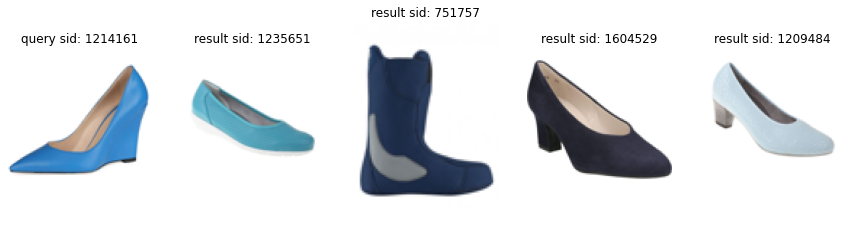

In [12]:
import matplotlib.pyplot as plt


class SearchResultVisualizer:
    def __init__(self, thumbnails_for_shoe_ids: dict, num_results: int = 5):
        self.thumbnails_for_shoe_ids = thumbnails_for_shoe_ids
        self.num_results = num_results
        
    def visualize_query_and_most_similar_results(self, query_shoe_id: int, similar_shoe_ids: list, height: int = 15):
        num_results = len(similar_shoe_ids)
        num_tiles_in_row = 1 + num_results
        plt.figure(figsize=(height, height * num_tiles_in_row))
        for idx, sid in enumerate([query_shoe_id] + similar_shoe_ids):
            ax = plt.subplot(1, num_tiles_in_row, idx + 1, frameon=False)
            if idx == 0:
                plt.title(f'query sid: {sid}')
            else:
                plt.title(f'result sid: {sid}')
            ax.set_axis_off()
            plt.imshow(self.thumbnails_for_shoe_ids[sid])
        plt.show()


search_visualizer = SearchResultVisualizer(thumbnails_for_shoe_ids)


# Demo usage and results:
query_shoe_id = 1214161
most_similar_shoes = load_w2v.most_similar(positive=[pca_output[str(query_shoe_id)]], topn=5)
most_similar_shoes = list(list(zip(*most_similar_shoes))[0])
most_similar_shoes = list(map(int, most_similar_shoes))
most_similar_shoes.remove(query_shoe_id)
search_visualizer.visualize_query_and_most_similar_results(query_shoe_id, most_similar_shoes)

### 5 - Assess attribute match across most similar shoes derived from the embeddings
For any given query, compute the attribute match as the fraction of times that a shoe attribute of a retrieved shoe matches the attribute of the query. Aggregate suitably so that we have only one number per attribute describing the match (probability) across the whole dataset. Please comment on your findings. If you are running out of time, you may only look at the `category` attribute. 

In [13]:
from collections import Counter

In [14]:
def compute_attr_prob(field):
    counter_dict = dict(Counter(list(attributes[field])))
    prob_per_attribute = {k: v / total for total in (sum(counter_dict.values()),) \
                          for k, v in counter_dict.items()}
    return prob_per_attribute

prob_per_attribute = {col: compute_attr_prob(col) for col in attributes.columns}

In [15]:
attr_match_prob = dict()
def get_match_score(query_id, results_id):
    attr_match_prob['query_id'] = query_id
    attr_match_prob['results_id'] = results_id
    internal_dict = dict()
    for column in attributes.columns:
        query_attr = attributes[column].loc[query_id]
        result_attr = list(attributes[column].loc[results_id])
        result_attr_dict = dict(Counter(result_attr))
        try:
            query_result_attr_match = result_attr_dict[query_attr]
            query_result_attr_prob = query_result_attr_match / len(results_id)
            query_result_attr_prob_dataset = query_result_attr_prob * \
                                            prob_per_attribute[column][query_attr]
            internal_dict[column] = round(query_result_attr_prob_dataset, 2)
            attr_match_prob['attr_match_scores'] = internal_dict
        except KeyError:
            internal_dict[column] = 0.0
            attr_match_prob['attr_match_scores'] = internal_dict
    return attr_match_prob

In [16]:
#Get attribute match for one shoe from the most_similar_matches
get_match_score(query_shoe_id, [most_similar_shoes[3]])

{'query_id': 1214161,
 'results_id': [1209484],
 'attr_match_scores': {'category': 0.0,
  'age_group': 0.81,
  'brand': 0.0,
  'gender': 0.56}}

In [17]:
#Get attribute match for all shoes from the most_similar_matches
get_match_score(query_shoe_id, most_similar_shoes)

{'query_id': 1214161,
 'results_id': [1235651, 751757, 1604529, 1209484],
 'attr_match_scores': {'category': 0.0,
  'age_group': 0.81,
  'brand': 0.0,
  'gender': 0.42}}

### 6 - Decode and quantify the information content about the shoe category from the embedding vectors
Please use a method of your choice and estimate a scalar number quantifying how much information about the category these embeddings have. A practical quantification is more important than a formal or theoretical approach. Your measure should however allow you to arbitrate and make automated comparisons if we were to compare our present embeddings to differently computed ones in the future (e.g. produced by a different neural network model). Please speculate about potential deficiencies of these embeddings and how you would go about assessing them. If you still have time, you are of course welcome to show an analysis as well.

### 7 - Summarize and comment on the quality of the embeddings
Picture yourself explaining to a product manager whether such a similarity-based search project is a promising business use case. 
Additionally, feel free to mention any extensions to your analysis you would do if you had more time.

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns
import operator

In [40]:
tsne = TSNE(random_state = 42, 
            n_iter = 1000, 
            metric = 'cosine', 
            n_components=2)

In [49]:
def plot_tnse(input_dict, col_name):
    emd_2D = tsne.fit_transform(np.array([*input_dict.values()]))
    shoe_ids = list(map(int, list(input_dict.keys())))
    group_ids = attributes.loc[shoe_ids][col_name].to_list()

    emb_df = pd.DataFrame()
    emb_df[col_name] = group_ids
    emb_df['x_col'] = emd_2D[:,0]
    emb_df['y_col'] = emd_2D[:,1]

    plt.figure(figsize=(25,10))
    sns.scatterplot(
        x='x_col', y='y_col',
        hue=col_name,
        data=emb_df,
        legend="full",
        alpha=0.3
        )

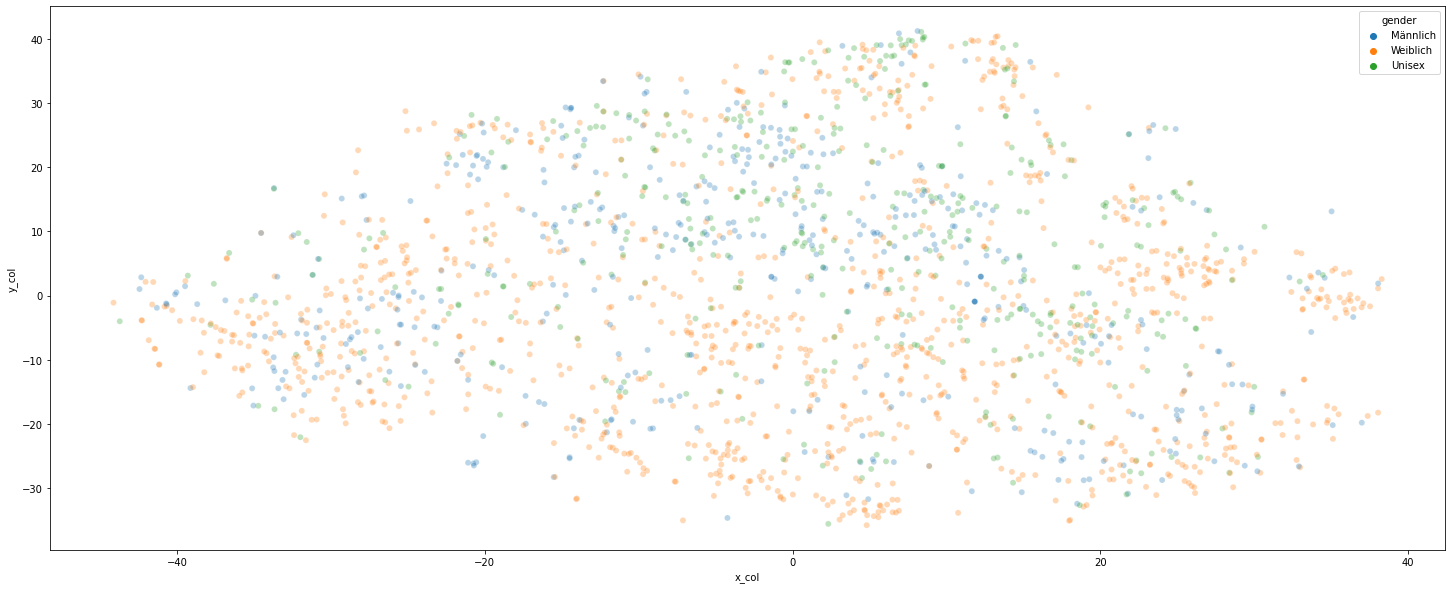

In [50]:
plot_tnse(pca_output, 'gender')

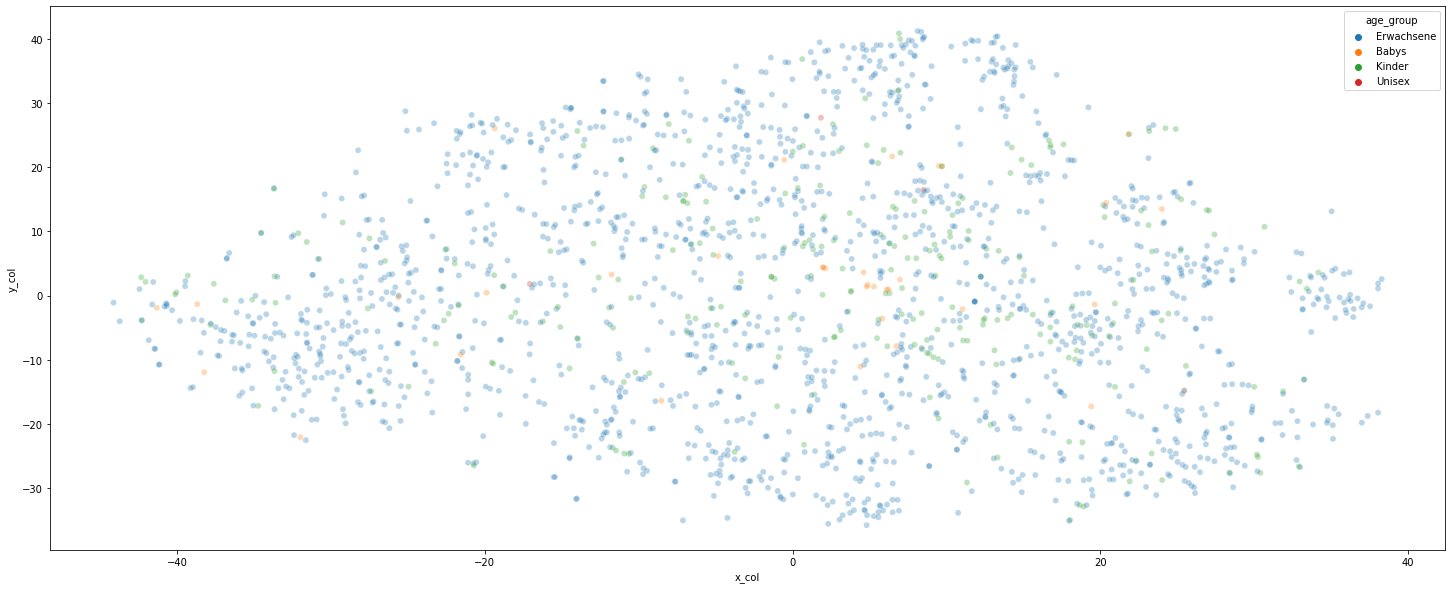

In [51]:
plot_tnse(pca_output, 'age_group')

#### Inference 
* From the above plots we can comprehend that the embeddings are not well clustered based on their orientation to the chosen attribute. 
* The implemented prototype to retrieve the similar shoes for a query works satisfactorily, but after looking at the TNSE plot to assess the quality of the embeddings, we cannot assure the same performance in a production setting. 

There are too many categories and brands which makes the visualization difficult as distinction between the groups is not percievable in the plot. Therefore they are not plotted.

In [59]:
#category_dict = Counter(attributes['category'])
#top_cats = category_dict.most_common(15)
#selected_cats = map(operator.itemgetter(0), top_cats)

### Pros and Cons of adapting Similarity-based Search system

Pros

* This method of comparing the similarity between the query and the catalogue to retrieve the most similar products can replace the existing systems.

* The existing systems in the industry possess an overhead as they require a relational database(eg:PostgreSQL), to store attributes and relationships between the products, together with a full-text search engine (eg:Elasticsearch), which is used to index the product titles.

* Using similarity-based search will provide us with more degree of freedom to tweak the weights given to each attribute of the products. Eventually enabling us to enrich the results based on the order of significance of the attributes.

* The same method can be used for multi-purpose applications, one such being "Alternative Products Recommender" where we could suggest similar products to the product the visitor is viewing at an instance. 

* Using this method will certainly reduce the zero hits in case an exact matching product is not available. Because when we use the vector space to search for the matching results we are comparing the query against the catalogue in terms of 100 to 300 or even more dimensions which cannot be percieved by full-text search engine.

Cons
* The computational time to retrieve similar products increases with increase in the dimension of the embeddings. But this can be countered by using appropriate indexer for example ANNOY indexer from spotify.